In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('all_seasons.csv')

print(df.head())

# Basic Data Cleaning
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)
    
df.columns = df.columns.str.strip()
df['pts'] = pd.to_numeric(df['pts'], errors='coerce')

   Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           4      George Zidek               DEN  23.0         213.36   

   player_weight                college country draft_year draft_round  ...  \
0      94.800728        Louisiana State     USA       1996           2  ...   
1      86.182480  Northwestern Oklahoma     USA       1994           2  ...   
2     103.418976         North Carolina     USA       1993           1  ...   
3     102.058200          Florida State     USA       1989           1  ...   
4     119.748288                   UCLA     USA       1995           1  ...   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0

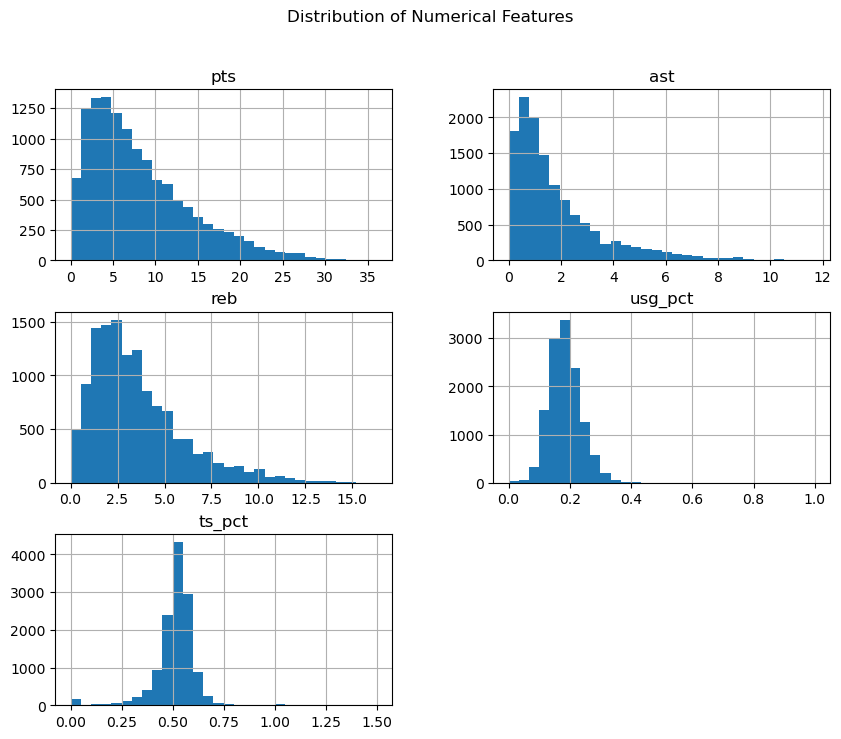

In [3]:
# Data Analysis Histogram and Heatmap
numerical_cols = ['pts', 'ast', 'reb', 'usg_pct', 'ts_pct']
df[numerical_cols].hist(bins = 30, figsize = (10, 8))
plt.suptitle('Distribution of Numerical Features')
plt.show()

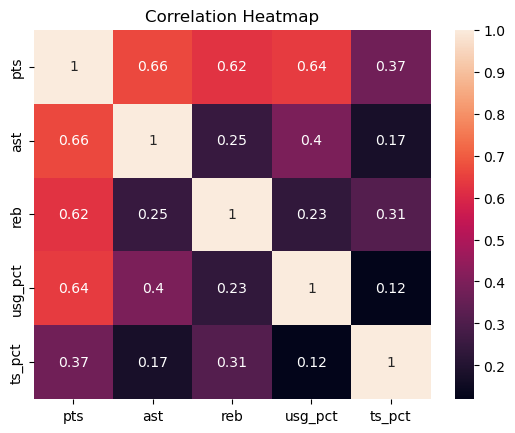

In [4]:
sns.heatmap(df[numerical_cols].corr(), annot = True)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Feature Engineering
median_pts = df['pts'].median()
df['High_Scorer'] = (df['pts'] > median_pts).astype(int)
df['draft_year'] = pd.to_numeric(df['draft_year'], errors = 'coerce')

# Handling Missing Values
df.dropna(subset = ['pts', 'High_Scorer'], inplace = True)

# Ensuring numeric columns are just numeric
# Replacing 'Undrafted' or other non-numeric strings with nan
df['draft_round'] = df['draft_round'].replace('Undrafted', np.nan)
df['draft_number'] = df['draft_number'].replace('Undrafted', np.nan)
df['draft_round'] = pd.to_numeric(df['draft_round'], errors = 'coerce')
df['draft_number'] = pd.to_numeric(df['draft_number'], errors = 'coerce')

numeric_cols = ['age','player_height','player_weight','draft_year','draft_round','draft_number','gp','net_rating','oreb_pct','dreb_pct','usg_pct','ts_pct','ast_pct']

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = ['college', 'country', 'season', 'team_abbreviation']

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert draft_round and draft_number to int after filling
df['draft_round'] = df['draft_round'].fillna(0).astype(int)
df['draft_number'] = df['draft_number'].fillna(0).astype(int)

# Prepare Features and Targets
X = df.drop(columns = ['pts', 'High_Scorer', 'player_name'], errors = 'ignore')
y_reg = df['pts']
y_clf = df['High_Scorer']

# Split Data for Regression and Classification
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size = 0.2, random_state = 42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size = 0.2, random_state = 42)

# One-Hot Encoding
encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore')
encoder.fit(X_train_reg[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols)

X_train_reg_enc = pd.DataFrame(encoder.transform(X_train_reg[categorical_cols]), columns = encoded_cols, index = X_train_reg.index)
X_test_reg_enc = pd.DataFrame(encoder.transform(X_test_reg[categorical_cols]), columns = encoded_cols, index = X_test_reg.index)
X_train_clf_enc = pd.DataFrame(encoder.transform(X_train_clf[categorical_cols]), columns = encoded_cols, index = X_train_clf.index)
X_test_clf_enc = pd.DataFrame(encoder.transform(X_test_clf[categorical_cols]), columns = encoded_cols, index = X_test_clf.index)

if 'player_name' in X.columns:
    categorical_cols.append('player_name')

X_train_reg_num = X_train_reg.drop(columns = categorical_cols)
X_test_reg_num = X_test_reg.drop(columns = categorical_cols)
X_train_clf_num = X_train_clf.drop(columns = categorical_cols)
X_test_clf_num = X_test_clf.drop(columns = categorical_cols)

X_train_reg_final = pd.concat([X_train_reg_num, X_train_reg_enc], axis = 1)
X_test_reg_final = pd.concat([X_test_reg_num, X_test_reg_enc], axis = 1)
X_train_clf_final = pd.concat([X_train_clf_num, X_train_clf_enc], axis = 1)
X_test_clf_final = pd.concat([X_test_clf_num, X_test_clf_enc], axis = 1)

# Scaling
features_to_scale = ['age','player_height','player_weight','draft_year','draft_round','draft_number','gp','net_rating','oreb_pct','dreb_pct','usg_pct','ts_pct','ast_pct']

scaler = MinMaxScaler()
scaler.fit(X_train_reg_final[features_to_scale])

X_train_reg_final[features_to_scale] = scaler.transform(X_train_reg_final[features_to_scale])
X_test_reg_final[features_to_scale] = scaler.transform(X_test_reg_final[features_to_scale])
X_train_clf_final[features_to_scale] = scaler.transform(X_train_clf_final[features_to_scale])
X_test_clf_final[features_to_scale] = scaler.transform(X_test_clf_final[features_to_scale])

In [6]:
# Regression Model
linreg = LinearRegression()
linreg.fit(X_train_reg_final, y_train_reg)
y_pred_reg = linreg.predict(X_test_reg_final)

print(f"Linear Regression MSE: {mean_squared_error(y_test_reg, y_pred_reg)}")
print(f"Linear Regression R² Score: {r2_score(y_test_reg, y_pred_reg)}")

Linear Regression MSE: 3.92730818180357
Linear Regression R² Score: 0.8928014363644116


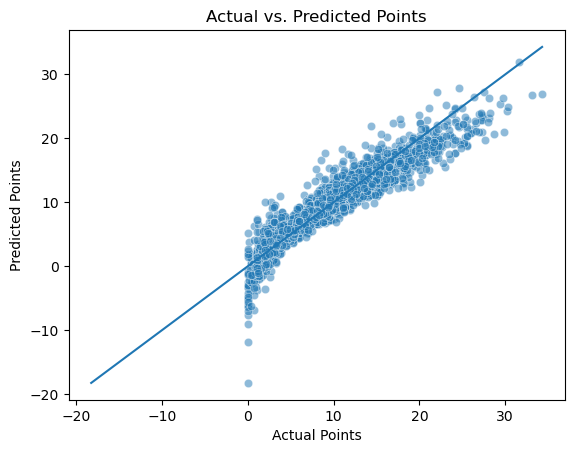

In [7]:
# Scatterplot Visualization for Regression
sns.scatterplot(x = y_test_reg, y = y_pred_reg, alpha = 0.5)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs. Predicted Points')
min_val = min(y_test_reg.min(), y_pred_reg.min())
max_val = max(y_test_reg.max(), y_pred_reg.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.show()

In [8]:
# Classification Model
logclf = LogisticRegression(max_iter = 1000, random_state = 42)
logclf.fit(X_train_clf_final, y_train_clf)
y_pred_clf = logclf.predict(X_test_clf_final)

print(f"Logistic Regression Classifier Accuracy: {accuracy_score(y_test_clf, y_pred_clf)}")
print(f"Logistic Regression Classifier Precision: {precision_score(y_test_clf, y_pred_clf)}")
print(f"Logistic Regression Classifier Recall: {recall_score(y_test_clf, y_pred_clf)}")
print(f"Logistic Regression Classifier F1 Score: {f1_score(y_test_clf, y_pred_clf)}")

Logistic Regression Classifier Accuracy: 0.9264305177111717
Logistic Regression Classifier Precision: 0.939538583929992
Logistic Regression Classifier Recall: 0.9126738794435858
Logistic Regression Classifier F1 Score: 0.9259114072912583


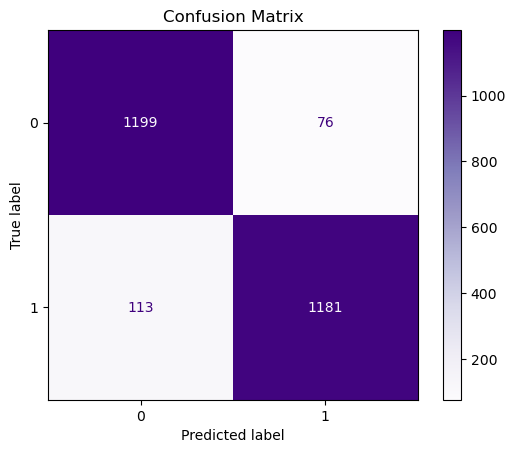

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1275
           1       0.94      0.91      0.93      1294

    accuracy                           0.93      2569
   macro avg       0.93      0.93      0.93      2569
weighted avg       0.93      0.93      0.93      2569



In [9]:
# Confusion Matrix for Classification
cm = confusion_matrix(y_test_clf, y_pred_clf)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1]).plot(cmap = 'Purples')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf))